<a href="https://colab.research.google.com/github/EternalSorrrow/transformer-feedforward-kernel/blob/main/bpe_classification_setup_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Nov 10 08:08:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/google-research/long-range-arena.git

Cloning into 'long-range-arena'...
remote: Enumerating objects: 474, done.
remote: Counting objects: 100% (474/474), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 474 (delta 330), reused 418 (delta 278), pack-reused 0
Receiving objects: 100% (474/474), 153.25 KiB | 6.13 MiB/s, done.
Resolving deltas: 100% (330/330), done.


In [ ]:
#Execute if A100 is the current GPU

!pip3 install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.3 MB/s eta 0:15:54tcmalloc: large alloc 1147494400 bytes == 0x55c1d0fcc000 @  0x7f81a534d615 0x55c1981ef4cc 0x55c1982cf47a 0x55c1981f22ed 0x55c1982e3e1d 0x55c198265e99 0x55c1982609ee 0x55c1981f3bda 0x55c198265d00 0x55c1982609ee 0x55c1981f3bda 0x55c198262737 0x55c1982e4c66 0x55c198261daf 0x55c1982e4c66 0x55c198261daf 0x55c1982e4c66 0x55c198261daf 0x55c1981f4039 0x55c198237409 0x55c1981f2c52 0x55c198265c25 0x55c1982609ee 0x55c1981f3bda 0x55c198262737 0x55c1982609ee 0x55c1981f3bda 0x55c198261915 0x55c1981f3afa 0x55c198261c0d 0x55c1982609ee
     |████████████████▌               | 1055.7 MB 1.2 MB/s eta 0:13:53tcmalloc: large alloc 1434370048 bytes == 0x55c215622000 @  0x7f81a534d615 0x55c1981ef4cc 0x55c1982cf47a 0x55c1981f22ed 0x55c1982e3e1d 0x55c198265e99 0x55c1982609ee 0x55c1981f3bda 0x55c198265d00 0x55c1982609ee 0x55c1981f3bda 0x55c198262737 0x55c1982e4c66 0x55c198261d

In [ ]:
%cd /content/long-range-arena

import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from lra_benchmarks.text_classification.input_pipeline import get_tc_datasets

batch_size=32
accumulation_steps=32 // batch_size
max_length=4000

train_dataset, valid_dataset, test_dataset, encoder = get_tc_datasets(1, 'imdb_reviews', batch_size=batch_size, max_length=max_length)

/content/long-range-arena
INFO:tensorflow:Finished preprocessing


INFO:tensorflow:Finished preprocessing


INFO:tensorflow:<MapDataset shapes: {Source: (), Target: ()}, types: {Source: tf.string, Target: tf.int64}>


INFO:tensorflow:<MapDataset shapes: {Source: (), Target: ()}, types: {Source: tf.string, Target: tf.int64}>


In [ ]:
sample = next(iter(train_dataset))['inputs']

for i in range(min(4, batch_size)):
  print(encoder.decode(sample[i]))

Obviously, there wasn't a huge budget for this film which definitely hindered the production. But the story and ending were so brutal that they made up for a lot. I mean brutal on the level of Ju Dou and other (great) Chinese films. I first saw this when I was 14 years old, I ran home and begged God to forgive me for everything...
Tara Reid as an intellectual, Christian Slater(usually great) as a dollar store Constantine and Stephen Dorff as...well it's STEPHEN DORFF FOR Christ SAKE!!!! I personally just want to thank those brilliant casting directors for the hard work and effort. You guys are on. Heres an idea, just my humble lowly opinion as the movie going public but it follows directly with your previous choices,a movie about the most brilliant neuro-physicist in history invent one pill to cure all diseases ever known to man and get this, heres the clincher they have to be played by Jessica Simpson and Paris Hilton. I knew you guys would love that. Seriously though you owe me $7.50

In [ ]:
import torch.nn as nn
import math

class TEmbedding(nn.Module):
  def __init__(self, num_embeddings, hidden_dim, seq_length=1024, padding_idx=0):
    super(TEmbedding, self).__init__()
    
    self.num_embeddings = num_embeddings
    self.hidden_dim=hidden_dim
    self.seq_length = seq_length
    self.padding_idx = padding_idx

    self.embedding = nn.Embedding(num_embeddings, hidden_dim, padding_idx)
    self.pos_embeds  = nn.Parameter(torch.zeros(1, self.seq_length, self.hidden_dim))

    self.cls = nn.Parameter(torch.zeros(1, 1, self.hidden_dim)) #!!!!!!! INIT WITH ANOTHER VALUE IF REQUIRED

  def forward(self, input):
    batch_size, seq_len = input.shape
    
    embed = self.embedding(input)
    embed = embed + self.pos_embeds
    embed = torch.cat([ self.cls.expand(batch_size, 1, -1), embed ], axis=1)

    return embed
    

class TAttention(nn.Module):
  def __init__(self, hidden_dim, num_heads, dropout_rate):
    super(TAttention, self).__init__()
    self.hidden_dim=hidden_dim
    self.num_heads =num_heads
    
    assert not hidden_dim % num_heads
    
    self.head_dim =hidden_dim // num_heads

    self.q = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.k = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.v = nn.Linear(self.hidden_dim, self.hidden_dim)

    self.lin = nn.Linear(self.hidden_dim, self.hidden_dim)

    self.dropout = nn.Dropout(dropout_rate)

  def split_heads(self, x):
    new_shape = x.shape[:-1] + (self.num_heads, self.head_dim)
    x = x.view(* new_shape)
    return x.permute(0, 2, 1, 3)

  def forward(self, x, losses=[]):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    q, k, v = self.split_heads(q), self.split_heads(k), self.split_heads(v)
    q = torch.mul(q, 1. / torch.sqrt(torch.tensor(self.hidden_dim)))

    qk = torch.matmul(q, k.transpose(-1, -2))
    qk = nn.Softmax(dim=-1)(qk)

    def assertion_function(tsr):
      tsr = torch.sum(tsr, axis=-1)
      tsr = tsr - torch.ones_like(tsr)
      return torch.max(torch.abs(tsr)) < 1e-5

    assert assertion_function(qk)

    qk = self.dropout(qk) #Like in TF implementation; could be done before Softmax by random -inf addition

    out = torch.matmul(qk, v)
    out = out.permute(0, 2, 1, 3)

    new_shape = out.shape[:-2] + (self.hidden_dim,)

    out = out.reshape(* new_shape)

    out = self.lin(out)

    return out

class HWLinear(nn.Module):
  def __init__(self, num_heads, input_dim, output_dim, use_bias):
    super(HWLinear, self).__init__()
    
    self.use_bias = use_bias
    if use_bias:
      self.bias   = nn.Parameter(torch.zeros( (1, num_heads, 1, output_dim)))

    self.weight = nn.Parameter(torch.empty( (num_heads, input_dim, output_dim)))

    def he_init(m):
      s =  np.sqrt( 2. / input_dim )
      m.data.normal_(0, s)

    he_init(self.weight)

  def forward(self, x):
    x = torch.matmul(x, self.weight)
    if self.use_bias:
      x += self.bias
    return x

class Lambda(nn.Module):
  def __init__(self, lambda_, objects=None):
      super(Lambda, self).__init__()
      self.lambda_ = lambda_
      self.objects = objects

  def forward(self, x):
    if self.objects is not None:
      return self.lambda_(self.objects, x)
    return self.lambda_(x)

class LKAAttention(nn.Module):
  def __init__(self, hidden_dim, num_heads, dropout_rate):
    super(LKAAttention, self).__init__()
    self.hidden_dim=hidden_dim
    self.num_heads =num_heads

    assert not hidden_dim % num_heads
    
    self.head_dim =hidden_dim // num_heads
    
    self.q = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.k = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.v = nn.Linear(self.hidden_dim, self.hidden_dim)

    #self.lka = nn.Sequential(
    #  nn.Linear(self.head_dim, self.head_dim), nn.GELU(),
    #  nn.Linear(self.head_dim, self.head_dim), nn.Softplus(beta=2.5),
    #)

    #256, 4, 16, 1024
    #256, 64, 1, 1024
    class AMGOLU(nn.Module):
      def __init__(self, num_heads, hidden_dim, gate_rank, dropout_rate, gate_nonlinearity, kernel_nonlinearity, use_bias=False):
        super(AMGOLU, self).__init__()

        self.head_dim = hidden_dim // num_heads
        self.num_heads= num_heads
        
        self.orth_weight = HWLinear(num_heads, self.head_dim, self.head_dim, use_bias)
        self.orth_weight.weight = nn.Parameter(torch.stack([ nn.init.orthogonal_(torch.empty((self.head_dim, self.head_dim))) for _ in range(num_heads) ], dim=0))

        self.gate_weight_a = HWLinear(num_heads, self.head_dim, gate_rank, use_bias)
        self.gate_weight_b = HWLinear(num_heads, gate_rank, self.head_dim, use_bias)

        self.kernel_nonlinearity = kernel_nonlinearity
        self.gate_nonlinearity   = gate_nonlinearity

        self.dropout = nn.Dropout(dropout_rate)

      def forward(self, x):
        x, losses = x
        x = self.dropout(x)

        forward_info = self.orth_weight(x)
        forward_info = self.kernel_nonlinearity(forward_info)

        gate_info = self.gate_weight_a(x)
        gate_info = self.gate_weight_b(gate_info)
        gate_info = self.gate_nonlinearity(gate_info)

        x = forward_info * gate_info
        
        loss = torch.eye(self.head_dim, device=self.orth_weight.weight.device).unsqueeze(0).expand(self.num_heads, -1, -1)
        loss = nn.MSELoss()(torch.matmul(self.orth_weight.weight, self.orth_weight.weight.transpose(-1, -2)), loss)
        loss *= 0.001

        losses.append(loss)

        return x, losses



    class GatedOrthoKernel(nn.Module):
      def __init__(self, num_heads, hidden_dim, dropout_rate=0.1, gate_nonlinearity=nn.Sigmoid(), kernel_nonlinearity=nn.Identity(), use_bias=False):
        super(GatedOrthoKernel, self).__init__()

        self.head_dim = hidden_dim // num_heads
        self.num_heads = num_heads

        self.orth_weight = HWLinear(num_heads, self.head_dim, self.head_dim, use_bias)
        self.orth_weight.weight = nn.Parameter(torch.stack([ nn.init.orthogonal_(torch.empty((self.head_dim, self.head_dim))) for _ in range(num_heads) ], dim=0))
        self.gate_weight = HWLinear(num_heads, self.head_dim, self.head_dim, use_bias)

        self.kernel_nonlinearity = kernel_nonlinearity
        self.gate_nonlinearity   = gate_nonlinearity

        self.dropout = nn.Dropout(dropout_rate)

      def forward(self, x):
        x, losses = x
        x = self.dropout(x)

        x = self.kernel_nonlinearity(self.orth_weight(x)) * self.gate_nonlinearity(self.gate_weight(x))
        
        loss = torch.eye(self.head_dim, device=self.orth_weight.weight.device).unsqueeze(0).expand(self.num_heads, -1, -1)
        loss = nn.MSELoss()(torch.matmul(self.orth_weight.weight, self.orth_weight.weight.transpose(-1, -2)), loss)
        loss *= 0.01

        losses.append(loss)

        return x, losses


    class HeadWiseFF(nn.Module):
      def __init__(self, num_heads, hidden_dim, dropout_rate, nonlinearity=nn.Identity(), use_bias=False, residual=False):
        super(HeadWiseFF, self).__init__()
        
        head_dim = hidden_dim // num_heads

        self.bias   = nn.Parameter(torch.empty( (1, num_heads, 1, head_dim)))
        self.dropout= nn.Dropout(dropout_rate)
        self.use_bias = use_bias

        self.weight = nn.Parameter(torch.empty( (num_heads, head_dim, head_dim)))
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

        #Orthogonal initialization
        #Workaround with torch.stack, since Torch initializes a tensor as orthgonal by flattening its trailing dims and QR-factorizing the resulting 2d
        
        #self.weight = torch.stack([ nn.init.orthogonal_(torch.empty((head_dim, head_dim))) for _ in range(num_heads) ], dim=0)
        #self.weight = nn.Parameter(self.weight)

        bound = 1 / math.sqrt(head_dim)
        nn.init.uniform_(self.bias, -bound, bound)

        self.nonlinearity = nonlinearity
        self.residual= residual

      def forward(self, x):
        
        x, losses = x

        bs, hd, seq, hdim = x.shape
        y = self.dropout(x)
        y = torch.matmul(y, self.weight) #BS, HD, SEQ, HDIM
        if self.use_bias:
          y += self.bias
        y = self.nonlinearity(y)

        #loss = torch.eye(hdim, device=self.weight.device).unsqueeze(0).expand(* self.weight.shape)
        #loss = nn.MSELoss()(torch.matmul(self.weight, self.weight.transpose(-1, -2)), loss)
        #loss *= 0.005

        #losses.append(loss)

        if self.residual:
          return x + y, losses
        return y, losses

    class VampKernel(nn.Module):
      def __init__(self, num_heads, hidden_dim, latent_dim, num_pseudoinputs, nonlinearity=nn.Softplus(), use_bias=True):
        super(VampKernel, self).__init__()

        head_dim = hidden_dim // num_heads
        self.head_dim = head_dim
        self.use_bias = use_bias
        self.num_heads= num_heads
        self.nonlinearity=nonlinearity

        #Encoder q(z2 | x)
        self.q_z2_x = nn.Sequential(
            HWLinear(num_heads, head_dim, latent_dim, use_bias),
            nn.GELU()
        )

        self.q_z2_mean    = HWLinear(num_heads, latent_dim, latent_dim, use_bias)
        self.q_z2_log_var = nn.Sequential(
            HWLinear(num_heads, latent_dim, latent_dim, use_bias),
            Lambda(lambda x: torch.tanh(x) * 4.0 - 2.0)
        )

        #Encoder q(z1 | x, z2)
        self.q_z1_x = nn.Sequential(
            HWLinear(num_heads, head_dim, latent_dim, use_bias),
            nn.GELU()
        )

        self.q_z1_z2 = nn.Sequential(
            HWLinear(num_heads, latent_dim, latent_dim, use_bias),
            nn.GELU()
        )

        #self.q_z1_joint = HWLinear(num_heads, latent_dim * 2, latent_dim, use_bias)

        self.q_z1_mean   = HWLinear(num_heads, latent_dim * 2, latent_dim, use_bias)
        self.q_z1_log_var= nn.Sequential(
            HWLinear(num_heads, latent_dim * 2, latent_dim, use_bias),
            Lambda(lambda x: torch.tanh(x) * 4.0 - 2.0)
        )

        #Decoder p(z1 | z2)
        self.p_z1_z2_mean = HWLinear(num_heads, latent_dim, latent_dim, use_bias)
        self.p_z1_z2_log_var = nn.Sequential(
            HWLinear(num_heads, latent_dim, latent_dim, use_bias),
            Lambda(lambda x: torch.tanh(x) * 4.0 - 2.0)
        )

        #Decoder p(x | z1, z2)
        self.p_x_z1 = nn.Sequential(
            HWLinear(num_heads, latent_dim, latent_dim, use_bias),
            nn.GELU()
        )

        self.p_x_z2 = nn.Sequential(
            HWLinear(num_heads, latent_dim, latent_dim, use_bias),
            nn.GELU()
        )

        #self.p_x_joint = HWLinear(num_heads, latent_dim * 2, latent_dim, use_bias)
        self.p_x_mean  = HWLinear(num_heads, latent_dim * 2, head_dim, use_bias)

        #Pseudoinputs
        self.means = nn.Sequential(
            HWLinear(num_heads, num_pseudoinputs, head_dim, False),
            nn.Tanh(),
        )
        self.dummy = nn.Parameter(torch.stack([ torch.eye(num_pseudoinputs) ] * num_heads, dim=0), requires_grad=False)

      def reparameterize(self, mu, log_var):
        if self.training:
          return mu
        
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mu + eps * std

      def log_p_z2(self, z2):
        #TODO
        X = self.means(self.dummy)
        HD, C, HDIM = X.shape
        
        pseudo_z2 = self.q_z2_x(X)
        pseudo_z2_mean, pseudo_z2_log_var = self.q_z2_mean(pseudo_z2), self.q_z2_log_var(pseudo_z2)

        #z2 = BS x HD x SEQ x HDIM
        #pseudo = HD x C x HDIM
        
        #expand to BS x HD x SEQ x 1 x HDIM
        #epxnad to  1 x HD x   1 x C x HDIM
        z2 = z2.unsqueeze(-2)
        pseudo_z2_mean = pseudo_z2_mean.unsqueeze(0).unsqueeze(2)
        pseudo_z2_log_var = pseudo_z2_log_var.unsqueeze(0).unsqueeze(2)

        return self.log_Normal_diag(z2, pseudo_z2_mean, pseudo_z2_log_var)
        

      def log_Normal_diag(self, x, mean, log_var, reduction=torch.mean):
          log_normal = -0.5 * ( log_var + torch.pow(x - mean, 2) / torch.exp(log_var) )
          return reduction( log_normal )

      def add_losses(self, losses, z1, z2, z1_p_mean, z1_p_logvar, z1_q_mean, z1_q_logvar, z2_q_mean, z2_q_logvar):
        #Reconstruction if needed
        #...

        #KLD
        log_p_z1 = self.log_Normal_diag(z1, z1_p_mean, z1_p_logvar)
        log_q_z1 = self.log_Normal_diag(z1, z1_q_mean, z1_q_logvar)
        log_p_z2 = self.log_p_z2(z2)
        log_q_z2 = self.log_Normal_diag(z2, z2_q_mean, z2_q_logvar)

        kld = -(log_p_z1 + log_p_z2 - log_q_z1 - log_q_z2)
        losses.append(kld)

      def forward(self, x):
        x, losses = x

        z2 = self.q_z2_x(x)
        z2_mean, z2_log_var = self.q_z2_mean(z2), self.q_z2_log_var(z2)
        z2 = self.reparameterize(z2_mean, z2_log_var)

        z1 = self.q_z1_x(x)
        z1_z2 = self.q_z1_z2(z2)
        z1 = torch.cat([ z1, z1_z2 ], dim=-1)
        z1_mean, z1_log_var = self.q_z1_mean(z1), self.q_z1_log_var(z1)
        z1 = self.reparameterize(z1_mean, z1_log_var)

        z1_p_mean, z1_p_logvar = self.p_z1_z2_mean(z2), self.p_z1_z2_log_var(z2)

        self.add_losses(losses, z1, z2, z1_p_mean, z1_p_logvar, z1_mean, z1_log_var, z2_mean, z2_log_var)
        
        x_z1 = self.p_x_z1(z1)
        x_z2 = self.p_x_z2(z2)

        output = torch.cat([ z_x1, x_z2 ], dim=-1)
        output = self.p_x_mean(output)

        self.add_losses(losses, z1, z2, z1_p_mean, z1_p_logvar, z1_mean, z1_log_var, z2_mean, z2_log_var)

        return self.nonlinearity(output), losses

    class VariationalKernel(nn.Module):
      def __init__(self, num_heads, hidden_dim, latent_dim, nonlinearity=nn.Softplus(), use_bias=True):
        super(VariationalKernel, self).__init__()

        head_dim = hidden_dim // num_heads
        
        self.z_mean = HWLinear(num_heads, head_dim, latent_dim, use_bias)
        self.z_log_var = nn.Sequential(
            HWLinear(num_heads, head_dim, latent_dim, use_bias),
            Lambda(lambda x: torch.tanh(x) * 4.0 - 2.0)
        )

        self.out = HWLinear(num_heads, latent_dim, head_dim, use_bias)
        self.nonlinearity = nonlinearity

      def reparameterize(self, mu, log_var):
        if self.training:
          return mu
        
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mu + eps * std

      def add_kld(self, z_mean, z_log_var, losses, reduction=torch.mean):
        _, hd, _, _ = z_mean.shape

        for i in range(hd):
          kl_div = -0.5 * reduction(1 + z_log_var[:, i, :, :] - z_mean[:, i, :, :].pow(2) - z_log_var[:, i, :, :].exp())
          losses.append(kl_div)

      def forward(self, x):
        x, losses = x
        
        z_mean   = self.z_mean(x)
        z_log_var= self.z_log_var(x)

        z = self.reparameterize(z_mean, z_log_var)
        
        out = self.out(z)

        self.add_kld(z_mean, z_log_var, losses)

        ###############################
        return self.nonlinearity(out), losses
        ###############################

        ###############################
        #rec_loss = nn.MSELoss()(out, x)
        #losses.append(rec_loss)
        
        #return self.nonlinearity(z), losses
        ################################

    self.lka = nn.Sequential(
        
        #AMGOLU(self.num_heads, self.hidden_dim, self.head_dim // 4, dropout_rate, nn.Sigmoid(), nn.Identity(), False),
        #AMGOLU(self.num_heads, self.hidden_dim, self.head_dim // 4, dropout_rate, nn.Sigmoid(), nn.Identity(), False),
        #AMGOLU(self.num_heads, self.hidden_dim, self.head_dim // 4, dropout_rate, nn.Sigmoid(), nn.Softplus(), False),
        
        #HeadWiseFF(self.num_heads, self.hidden_dim, dropout_rate, nn.Softplus(), use_bias=False),
        
        Lambda(lambda o, x: (o['act'](x[0]), x[1]), { 'act' : nn.Identity() })
        
    )

    self.lin = nn.Linear(self.hidden_dim, self.hidden_dim)

    self.dropout = nn.Dropout(dropout_rate)

  def split_heads(self, x):
    new_shape = x.shape[:-1] + (self.num_heads, self.head_dim)
    x = x.view(* new_shape)
    return x.permute(0, 2, 1, 3)

  def forward(self, x, losses=[]):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    q, k, v = self.split_heads(q), self.split_heads(k), self.split_heads(v)
    #BS x HEADS x SEQ x HEAD_DIM
    
    q, _ = self.lka((q, losses))
    k, _ = self.lka((k, losses)) #Use this for var kernel

    q = q / math.sqrt(self.head_dim)
    k = k / math.sqrt(self.head_dim)

    numerator = torch.matmul(k.unsqueeze(-1), v.unsqueeze(-2))
    numerator = numerator.sum(axis=2)
    numerator = torch.matmul(q, numerator)
    
    denominator = k.sum(axis=2).unsqueeze(-1)
    denominator = q.matmul(denominator)

    out = numerator / denominator
    out = out.permute(0, 2, 1, 3)
    
    #TODO: INSERT DROPOUT
    
    new_shape = out.shape[:-2] + (self.hidden_dim,)
    out = out.reshape(* new_shape)

    out = self.lin(out)

    return out

class SimpleAttention(nn.Module):
  def __init__(self, hidden_dim, num_heads, dropout_rate):
    super(SimpleAttention, self).__init__()
    self.hidden_dim=hidden_dim
    self.num_heads =num_heads

    assert not hidden_dim % num_heads
    
    self.head_dim =hidden_dim // num_heads
    
    self.q = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.k = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.v = nn.Linear(self.hidden_dim, self.hidden_dim)

    self.dropout = nn.Dropout(dropout_rate)
    self.lin = nn.Linear(self.hidden_dim, self.hidden_dim)

  def split_heads(self, x):
    new_shape = x.shape[:-1] + (self.num_heads, self.head_dim)
    x = x.view(* new_shape)
    return x.permute(0, 2, 1, 3)

  def forward(self, x, losses=[]):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    q, k, v = self.split_heads(q), self.split_heads(k), self.split_heads(v) #BS x HEADS x SEQ x HEAD_DIM

    kv = torch.matmul(k.transpose(-1, -2), v)
    kv = self.dropout(kv)

    out = torch.matmul(q, kv)
    out = out.permute(0, 2, 1, 3)
    
    new_shape = out.shape[:-2] + (self.hidden_dim,)
    out = out.reshape(* new_shape)

    return out

class FtAttention(nn.Module):
  def __init__(self, *args, **kwargs):
    super(FtAttention, self).__init__()

  def forward(self, x, losses=[]):
    return torch.fft.fft(torch.fft.fft(x, dim=-1), dim=-2).real

class TBlock(nn.Module):
  def __init__(self, hidden_dim, inter_dim, num_heads, dropout_rate):
    super(TBlock, self).__init__()

    self.hidden_dim = hidden_dim
    self.inter_dim  = inter_dim

    self.layernorm_input = nn.LayerNorm(hidden_dim, eps=1e-6)
    self.layernorm_inter = nn.LayerNorm(hidden_dim, eps=1e-6)

    self.attention = TAttention(hidden_dim, num_heads, dropout_rate)

    self.ffn       = nn.Sequential(
        nn.Linear(hidden_dim, inter_dim), nn.GELU(), nn.Dropout(dropout_rate),
        nn.Linear(inter_dim, hidden_dim), nn.GELU(), nn.Dropout(dropout_rate),
    )


  def forward(self, input, losses=[]):
    x = self.layernorm_input(input)
    x = self.attention(x, losses)

    x = input + x

    y = self.layernorm_inter(x)
    x = self.ffn(y) + x

    return x

class TClassifier(nn.Module):
  def __init__(self, classes, hidden_dim, inter_dim, dropout_rate):
    super(TClassifier, self).__init__()

    self.layernorm = nn.LayerNorm(hidden_dim, eps=1e-6)
    self.dropout   = nn.Dropout(dropout_rate)

    self.ffn       = nn.Sequential(
        nn.Linear(hidden_dim, inter_dim), nn.GELU(),
    )
    self.output    = nn.Linear(inter_dim, classes)

  def forward(self, x):
    x = self.layernorm(x)
    x = x[:, 0, :]
    x = self.dropout(x)

    x = self.ffn(x)
    logits = self.output(x)

    return logits

class Transformer(nn.Module):
  def __init__(self, classes, num_embeddings, seq_len, hidden_dim=64, num_heads=4, num_blocks=8, output_units=512, internal_dropout_rate=0.1, output_dropout_rate=0.5):
    super(Transformer, self).__init__()

    inter_dim = 2 * hidden_dim
    
    self.embed_layer = TEmbedding(num_embeddings, hidden_dim, seq_len)
    self.blocks      = nn.ModuleList([ TBlock(hidden_dim, inter_dim, num_heads, internal_dropout_rate) for _ in range(num_blocks) ])
    self.classifier  = TClassifier(classes, hidden_dim, output_units, output_dropout_rate)

  def forward(self, pixel_values):
    additional_losses = []

    x = self.embed_layer(pixel_values)
    
    for block in self.blocks:
      x = block(x, additional_losses)
    
    x = self.classifier(x)

    return x, additional_losses

In [ ]:
def num_parameters(model):
  return sum(list(map(
      lambda x: np.prod(x[1].shape), model.named_parameters()
  )))

n_classes = 2

def model_factory():
  model = Transformer(
    classes   =n_classes,
    num_embeddings=encoder.vocab_size,
    seq_len=max_length,
    hidden_dim=256,
    num_heads =4,
    num_blocks=4,
    output_units=1024,
    internal_dropout_rate=0.1,
    output_dropout_rate=0.0
  ).cuda()
  
  orig_count = num_parameters(model)

  for block in model.blocks:
    #block.attention = FtAttention()
    #block.attention = LKAAttention(256, 4, 0.1).cuda()
    block.attention = SimpleAttention(256, 4, 0.1).cuda()
    ...
  
  new_count = num_parameters(model)
  print(f'Original model {orig_count} params, new model {new_count} params, ratio {new_count / orig_count:.3}')

  return model

Original model 3464194 params, new model 3464194 params, ratio 1.0


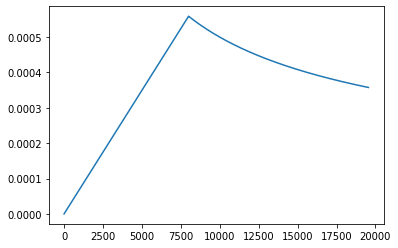

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

def get_schedule(warmup_steps):
  def lr_schedule(step):
    return 1.0 * np.minimum(1.0, step / warmup_steps) / np.sqrt(np.maximum(step, warmup_steps))

  return lr_schedule

lr=0.05
weight_decay=0.1
warmup=8000

def training_setup():
  model = model_factory()
  criterion = nn.CrossEntropyLoss().cuda()
  optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
  schedule_func = get_schedule(warmup)
  scheduler = LambdaLR(optimizer, schedule_func)

  return model, criterion, optimizer, schedule_func, scheduler

_, _, _, schedule_func, _ = training_setup()

plt.plot([ lr * schedule_func(i) for i in range(len(train_dataset) // accumulation_steps * 25) ])

In [ ]:
import time

def save_model(model, optimizer, name='/content/drive/MyDrive/Work/Misc/lka-mini-base.tar'):
  torch.save({
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              }, name)

def progress_bar(len, total, current):
  current_scaled = int(round(len * current / total))

  s = '[' + '=' * (current_scaled - 1)
  s += '>' if current != total else '='
  s += '-' * (len - current_scaled) + ']'

  return s

def accuracy(model_output, labels):
  model_output = model_output.argmax(dim=-1)

  return (labels == model_output).float().mean().cpu().numpy()

def train_model(model, name, train_dataset, valid_dataset, optimizer, criterion, scheduler, accumulation_steps, epochs, epoch_len=None, eps = 1e-6, skip_eval=25):
  
  best_acc = 0.0

  bnum = math.ceil(len(train_dataset) / accumulation_steps)
  train_dataset = train_dataset.shuffle(len(train_dataset), reshuffle_each_iteration=True)

  times_repeat = epochs if epoch_len is None else math.ceil(epochs * epoch_len / bnum)
  train_dataset = train_dataset.repeat(times_repeat)
  train_datagen = iter(train_dataset)
  
  if epoch_len is not None:
    bnum = epoch_len
  
  for epoch in range(epochs):  # loop over the dataset multiple times

      #epoch start timestamp
      t = time.time()

      running_loss = 0.0
      running_reg  = 0.0
      running_acc  = 0.0

      running_momentum = 0.99

      epoch_loss = [  ]
      epoch_reg  = [  ]
      epoch_acc  = [  ]

      model.train()

      print(f'Epoch {epoch}')

      process_inputs = lambda x: torch.Tensor(x.numpy()).to(torch.int64)

      for i in range(bnum):
          # zero the parameter gradients
          optimizer.zero_grad()

          #accumulate gradients for a certain amount of steps
          for k in range(accumulation_steps):
            # get the inputs; data is a list of [inputs, labels]

            try:
              data = next(train_datagen)
            except:
              break
            inputs, labels = data['inputs'], data['targets']
            inputs, labels = process_inputs(inputs), process_inputs(labels)
            inputs, labels = inputs.cuda(), labels.cuda()

            # forward + backward + optimize
            outputs, additional_losses = model(inputs)
            loss = criterion(outputs + eps, labels)

            additional_losses = sum(additional_losses) if additional_losses else torch.Tensor([ 0.0 ]).cuda()
            ((loss + additional_losses) / accumulation_steps).backward()

            acc = accuracy(outputs, labels)

            running_loss = running_loss * running_momentum + (1 - running_momentum) * loss.item()
            running_loss_unb = running_loss / (1 - running_momentum ** (i * accumulation_steps + k + 1))

            running_acc  = running_acc  * running_momentum + (1 - running_momentum) * acc
            running_acc_unb = running_acc / (1 - running_momentum ** (i * accumulation_steps + k + 1))

            running_reg  = running_reg  * running_momentum + (1 - running_momentum) * additional_losses.item()
            running_reg_unb = running_reg / (1 - running_momentum ** (i * accumulation_steps + k + 1))

            epoch_loss.append(loss.item())
            epoch_acc.append(acc)
            epoch_reg.append(additional_losses.item())

          optimizer.step()

          pbar = progress_bar(20, bnum, i + 1)

          print(f'\r{pbar} {i + 1}/{bnum}:', end='')
          print(f' - running_loss: {running_loss_unb:.4f} - running_reg: {running_reg_unb:.6f} - running_acc: {running_acc_unb:.4f} - lr: {scheduler.get_last_lr()[0]:.5f}', end='')

          scheduler.step()
      
      epoch_loss = np.mean(epoch_loss)
      epoch_acc  = np.mean(epoch_acc)
      epoch_reg  = np.mean(epoch_reg)
      
      print(f' - epoch_loss: {epoch_loss:.4f} - epoch_reg: {epoch_reg:.6f} - epoch_acc: {epoch_acc:.4f}', end='')

      epoch_loss, epoch_acc, epoch_reg = [], [], []

      
      if epoch >= skip_eval:
        model.eval()
        valid_dataset.repeat()

        with torch.no_grad():
          for i, data in enumerate(iter(valid_dataset)):
            inputs, labels = data['inputs'], data['targets']
            inputs, labels = process_inputs(inputs), process_inputs(labels)
            inputs, labels = inputs.cuda(), labels.cuda()

            outputs, aux_losses = model(inputs)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)
            aux_losses = sum(aux_losses) if aux_losses else torch.Tensor([ 0.0 ]).cuda()

            epoch_loss.append(loss.item())
            epoch_acc.append(acc)
            epoch_reg.append(aux_losses.item())

        epoch_loss, epoch_acc, epoch_reg = np.mean(epoch_loss), np.mean(epoch_acc), np.mean(epoch_reg)

        if epoch_acc > best_acc:
          best_acc = epoch_acc
          save_model(model, optimizer, name)
      
      else:
        epoch_loss, epoch_acc, epoch_reg = 0.0, 0.0, 0.0

      #epoch computing time
      t = time.time() - t

      print(f' - valid_loss: {epoch_loss:.4f} - valid_reg: {epoch_reg:.6f} - valid_acc: {epoch_acc:.4f} - epoch_time: {t:.4f} s')
 
  checkpoint = torch.load(name)
  return checkpoint

In [ ]:
def test(model, criterion, test_dataset):
  epoch_loss, epoch_acc, epoch_reg = [], [], []

  model.eval()
  test_dataset.repeat()

  process_inputs = lambda x: torch.Tensor(x.numpy()).to(torch.int64)

  t = time.time()

  with torch.no_grad():
    for i, data in enumerate(iter(test_dataset)):
      inputs, labels = data['inputs'], data['targets']
      inputs, labels = process_inputs(inputs), process_inputs(labels)
      inputs, labels = inputs.cuda(), labels.cuda()

      outputs, aux_losses = model(inputs)
      loss = criterion(outputs, labels)
      acc = accuracy(outputs, labels)
      aux_losses = sum(aux_losses) if aux_losses else torch.Tensor([ 0.0 ]).cuda()

      epoch_loss.append(loss.item())
      epoch_acc.append(acc)
      epoch_reg.append(aux_losses.item())

  t = time.time() - t

  epoch_loss, epoch_acc, epoch_reg = np.mean(epoch_loss), np.mean(epoch_acc), np.mean(epoch_reg)

  print(f' - test_loss: {epoch_loss:.4f} - test_reg: {epoch_reg:.6f} - test_acc: {epoch_acc:.4f} - test_time: {t:.4f} s')
  return epoch_loss, epoch_reg, epoch_acc

In [ ]:
test_accuracy = [  ]

for i in range(5): ####!!!!!!!!!!!!!!
  path = 'model_to_test_' + str(i) + '.b'

  model, criterion, optimizer, schedule_func, scheduler = training_setup()

  checkpoint = train_model(model, path, train_dataset, valid_dataset, optimizer, criterion, scheduler, accumulation_steps, 100, 200, skip_eval=15)
  model.load_state_dict(checkpoint['model_state_dict'])
  
  _, _, acc = test(model, criterion, test_dataset)
  test_accuracy.append(acc)

test_accuracy = np.mean(test_accuracy)

print(f'\nTotal accuracy: {test_accuracy:.4f}')

Original model 3464194 params, new model 3464194 params, ratio 1.0
Epoch 0
[====================] 200/200: - running_loss: 0.6928 - running_reg: 0.000000 - running_acc: 0.5250 - lr: 0.00001 - epoch_loss: 0.6944 - epoch_reg: 0.000000 - epoch_acc: 0.5214 - valid_loss: 0.0000 - valid_reg: 0.000000 - valid_acc: 0.0000 - epoch_time: 39.3252 s
Epoch 1
[====================] 200/200: - running_loss: 0.6869 - running_reg: 0.000000 - running_acc: 0.5364 - lr: 0.00003 - epoch_loss: 0.6888 - epoch_reg: 0.000000 - epoch_acc: 0.5308 - valid_loss: 0.0000 - valid_reg: 0.000000 - valid_acc: 0.0000 - epoch_time: 28.4367 s
Epoch 2
[====================] 200/200: - running_loss: 0.6898 - running_reg: 0.000000 - running_acc: 0.5401 - lr: 0.00004 - epoch_loss: 0.6901 - epoch_reg: 0.000000 - epoch_acc: 0.5402 - valid_loss: 0.0000 - valid_reg: 0.000000 - valid_acc: 0.0000 - epoch_time: 28.5065 s
Epoch 3
[====================] 200/200: - running_loss: 0.6838 - running_reg: 0.000000 - running_acc: 0.5602 - lr:

In [ ]:
3 x AOGLU l=0.0: 0.6610, 0.6571, 0.6601, 0.6568, 0.6622

In [ ]:
FFN l=0.005: 0.6585, 0.6530, 0.6589, 0.6601, 0.6594

In [ ]:
FFN noorth: 0.6582, 0.6456, 0.6605, 0.6591, 0.5521, | 0.6580, 0.6530

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output[0].detach()
    return hook

process_inputs = lambda x: torch.Tensor(x.numpy()).to(torch.int64)

list(model.blocks[-1].attention.lka.modules())[0][0].register_forward_hook(get_activation('1'))
#list(model.blocks[-1].attention.lka.modules())[0][1].register_forward_hook(get_activation('2'))

In [ ]:
model(process_inputs(next(iter(train_dataset))['inputs']).cuda())
activation

{'1': tensor([[[[0.4846, 0.6129, 1.0817,  ..., 0.8458, 0.8182, 0.6113],
           [0.6741, 1.0226, 0.9306,  ..., 0.6382, 0.4864, 0.4956],
           [0.7144, 0.7925, 0.9776,  ..., 0.8392, 0.8342, 0.6923],
           ...,
           [0.6351, 0.4956, 0.8323,  ..., 1.1306, 0.8587, 0.7959],
           [0.6259, 1.0617, 0.9905,  ..., 0.7249, 0.8088, 0.8153],
           [0.7734, 0.8578, 0.5455,  ..., 0.5648, 0.7239, 0.6971]],
 
          [[1.1219, 0.8068, 0.7288,  ..., 0.5271, 1.1042, 0.6128],
           [0.8955, 0.9000, 1.3224,  ..., 0.5096, 0.5674, 1.1289],
           [0.7283, 0.8557, 0.4822,  ..., 0.8176, 0.3683, 0.6196],
           ...,
           [0.6962, 0.6160, 0.4413,  ..., 1.0298, 0.8417, 0.8641],
           [1.0189, 0.9670, 0.5587,  ..., 0.9078, 0.7291, 0.7901],
           [0.6431, 0.5184, 0.5831,  ..., 0.6299, 0.6459, 0.6050]],
 
          [[0.6520, 0.8644, 0.8144,  ..., 0.5583, 0.4932, 0.5764],
           [0.3789, 0.7886, 0.5084,  ..., 0.7604, 0.5583, 0.4504],
           [0.8306,

In [ ]:
model, criterion, _, _, _ = training_setup()
tmp = next(iter(train_dataset))
outputs, aux_losses = model(process_inputs(tmp['inputs']).cuda())

aux_losses = sum(aux_losses)
(criterion(outputs, process_inputs(tmp['targets']).cuda()) + aux_losses).backward()

Original model 3464194 params, new model 3663874 params, ratio 1.06


In [ ]:
list(model.blocks[-1].attention.lka.modules())[0][0].output_bias

Parameter containing:
tensor([[[[-2.6187e-03, -5.7948e-04, -3.2907e-04,  6.2941e-04, -7.1119e-04,
           -4.3961e-04,  2.6415e-03,  9.3061e-04,  2.9606e-03, -2.6636e-04,
           -1.7387e-03,  1.6021e-03,  9.3624e-04,  1.1273e-03, -3.3982e-04,
           -4.0739e-04, -2.0149e-03,  9.0991e-04, -1.0498e-03, -2.7959e-03,
            2.5112e-04, -9.3633e-04,  6.2485e-04, -1.3612e-03, -2.9829e-04,
           -2.0080e-04,  7.8189e-04,  7.8589e-04, -5.3443e-03, -3.7092e-03,
           -2.3028e-04,  3.1588e-03, -2.2930e-04,  3.9736e-03,  4.0218e-04,
            1.0651e-03,  7.7839e-03,  1.8654e-04, -3.1373e-03,  1.4372e-03,
            4.1014e-03, -1.0334e-03, -8.9334e-04, -2.3530e-04, -1.0687e-03,
           -2.1504e-03, -1.1092e-03,  1.7172e-05,  1.2050e-03, -1.5283e-03,
            1.4103e-04, -2.1979e-03, -5.9292e-05,  2.5531e-03, -4.6291e-03,
            8.9993e-04,  5.3557e-05, -1.8944e-03,  6.1842e-04, -3.0434e-03,
           -2.6042e-03, -2.7910e-03,  1.9914e-03,  3.3585e-03]],

